### Imports and function definitions:

In [1]:
## region Import Dependencies and define functions:
import warnings
warnings.filterwarnings('ignore')

# For data processing & plotting:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as timer  # for timing code cells.
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import entropy
from scipy.signal import detrend

# For ML:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector  # For sequential feature sel.
from sklearn.model_selection import GridSearchCV, KFold, train_test_split  # To do parameter search
from sklearn import metrics

# Classifiers for CPU based computing:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression, Perceptron


# Only for GPU based computing: [ comment out on CPU ]
# import os  # Need both of these, run before importing cuml.

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# from cuml.svm import SVC
# from cuml.neighbors import KNeighborsClassifier
# from cuml.ensemble import RandomForestClassifier
# from sklearn.linear_model import RidgeClassifier


# Define function to read and normalize data:
def read_data(file_path, normalize=True):
    """
    File to read data in csv file
    :param file_path: path to the file, ex: data/11.csv
    :param normalize: if True, normalizes and detrends data
    :return: channel 1, channel 2, and time points.
    """
    # read data:
    data = pd.read_csv(file_path, header=None)
    # channel 1
    ch_1 = data.iloc[:, 1]
    ch_1 = (-ch_1 * 100) / (ch_1 - 1)
    # channel 2
    ch_2 = data.iloc[:, 2]
    ch_2 = (-ch_2 * 100) / (ch_2 - 1)
    # normalize:
    if normalize:
        def normalize(x):
            """
            Function to normalize using: X_n = ( X - X_min ) / ( X_max - X_min). Results in data in [0,1]
            :param x: Unormalized data
            :return: Normalized data
            """
            x_n = (x - np.min(x)) / (np.max(x) - np.min(x))
            return x_n

        ch_1 = normalize(detrend(ch_1))
        ch_2 = normalize(detrend(ch_2))

    return pd.Series(ch_1), pd.Series(ch_2)


# Define function to plot data:
def plot_data(ch1, ch2, title):
    # define time axis:
    time = np.arange(0, .015 * len(ch1), .015)  # 15 ms per time-point
    # plot
    fig, axs = plt.subplots(2, 1)

    fig.suptitle(title)
    axs[0].plot(time, ch1)
    axs[0].set_ylabel("Channel 1")
    axs[1].plot(time, ch2)
    axs[1].set_ylabel("Channel 2")
    plt.show()


# Define function to create labels
def create_labels(time_length, cough_event):
    """
    Function to create labels for coughing events.
    :param time_length: length of the time axis (typically 8000)
    :param cough_event: ND list with coughing events times
                        given as: [ [start,stop], [start, stop],... ]
    :return: coughing and non coughing labels
    """

    # create time axis:
    time = np.arange(0, .015 * time_length, .015)  # 15 ms per time-point

    # create label:
    labels = np.zeros(time.shape[0])

    for i in range(0, len(cough_event)):
        label = (time > cough_event[i][0]) * (time < cough_event[i][1])
        labels += label

    # Turn into Dataframe
    labels = pd.DataFrame(labels)
    labels = labels.iloc[:, 0]

    # create zero labels for data with no cough:
    label_nc = np.zeros(len(labels))
    label_nc = pd.DataFrame(label_nc)
    label_nc = label_nc.iloc[:, 0]

    return labels, label_nc


# Define function to plot labeled data:
def plot_labels(list_of_data):
    '''
    Function to plot dataset along with labels
    :param list_of_data:List of data to plot, along with labels
                        Format: [ [ch1, ch2,labels], [ch1, ch2, labels],...]
    :return: None
    '''
    # number of datasets:
    n_data = len(list_of_data)

    # define time axis:
    time = np.arange(0, .015 * len(list_of_data[0][0]), .015)

    # Initialize sub plots:
    fig, axs = plt.subplots(n_data, 2)

    # Iterate over datasets:
    for i in range(n_data):
        labels = list_of_data[i][2]
        # iterate over channels:
        for j in range(2):
            data = list_of_data[i][j]
            axs[i, j].plot(time, data, 'b', label='No Cough')
            axs[i, j].plot(time, data * labels, 'r', label='Cough')
            axs[i, j].set_ylim(data.min(), data.max())

            if i == 0:  # Set text "ch1 ch2" at top of graph:
                axs[i, j].set_title('Channel ' + str(j + 1))

            if j == 0:  # Set "DS 1" "DS 2" etc ( DS = Dataset )
                axs[i, j].set_ylabel('DS ' + str(i + 1))

        # set labels
        if i == n_data - 1:
            handles, dataset_labels = axs[i, j].get_legend_handles_labels()
            fig.legend(handles, dataset_labels, loc='upper right')

    plt.show()


# Define function to concatenate data into dataframe used for ML:
def concatenate_data(list_of_data_plt):
    """
    Function to concatenate data into a dataframe used for ML
    :param list_of_data: List of data to concatenate.
           Format: [ [ch1, ch2,labels], [ch1, ch2, labels],...]
    :return: Concatenated pd dataframe.
    """
    # initialize dataframe to concatenate data:
    data = pd.DataFrame(columns=[1, 2, 0])  # Needed to match automatic column name of data_temp for concatenation

    # iteratively populate dataframe:
    for i in range(len(list_of_data_plt)):
        data_temp = pd.concat(
            [list_of_data_plt[i][0].rename(1), list_of_data_plt[i][1].rename(2), list_of_data_plt[i][2].rename(0)],
            axis=1)
        data = pd.concat([data, data_temp])

    # Reset index and rename columns:

    name_list = ['Data ch1', 'Data ch2', 'Labels']
    data.columns = name_list
    # Reset index
    data.reset_index(drop=True, inplace=True)

    return data


# Define function to partition into windows and calculate window-wise metrics
def window_partition(data, n_channels, window_size, overlap, balanced=True):
    """
    Function to partition concatenated data into windows and perform various window wise metrics
    :param data: PD Dataframe with LABELED and normalized (if needed) concatenated data
    :param n_channels: 1=Only first channel, 2=only second channel, 3=both channels
    :param window_size: Window size
    :param overlap: Window overlap
    :return: PD Dataframe of metrics for input to ML model along with labels.
    """

    # Partition data:
    step_size = window_size - overlap
    # Initialize list to place windows:
    window_list = [[] for i in range(2)]
    window_list_fft = [[] for i in range(2)]
    # Initialize list to place labels:
    label_list = []

    # Do partitioning:
    for i in range(0, len(data), step_size):
        xs = data['Data ch1'].values[i:i + window_size]
        xs_2 = data['Data ch2'].values[i:i + window_size]
        lab = stats.mode(data['Labels'].values[i:i + window_size])[0][0]

        window_list[0].append(xs)  # Store windows from ch 1
        window_list[1].append(xs_2)  # Store windows from ch 2
        label_list.append(lab)  # Store labels

    # Initialize dataframe:
    X = pd.DataFrame()

    # Statistical Features on signal in time domain for channel 1:
    if n_channels == 1 or n_channels == 3:
        # mean
        X['x_mean'] = pd.Series(window_list[0]).apply(lambda x: x.mean())
        # std dev
        X['x_std'] = pd.Series(window_list[0]).apply(lambda x: x.std())
        # min
        X['x_min'] = pd.Series(window_list[0]).apply(lambda x: x.min())
        # max
        X['x_max'] = pd.Series(window_list[0]).apply(lambda x: x.max())
        # median
        X['x_median'] = pd.Series(window_list[0]).apply(lambda x: np.median(x))
        # number of peaks
        X['x_peak_count'] = pd.Series(window_list[0]).apply(lambda x: len(find_peaks(x)[0]))
        # skewness
        X['x_skewness'] = pd.Series(window_list[0]).apply(lambda x: stats.skew(x))
        # kurtosis
        X['x_kurtosis'] = pd.Series(window_list[0]).apply(lambda x: stats.kurtosis(x))
        # energy
        X['x_energy'] = pd.Series(window_list[0]).apply(lambda x: np.sum(x ** 2) / 100)
        # rms
        X['x_rms'] = pd.Series(window_list[0]).apply(lambda x: np.sqrt(np.mean(x ** 2)))

        # Statistical Features on signal in freq domain:
        # lim = int(window_size / 2)  # Take only half of the spectrum since symmetric.
        window_list_fft[0] = pd.Series(window_list[0]).apply(lambda x: np.abs(np.fft.fft(x))[1:])

        # Mean
        X['x_mean_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: np.mean(x))
        # Max Freq Index
        X['x_max_freq_idx'] = pd.Series(window_list_fft[0]).apply(lambda x: np.argmax(x))
        # Min Freq Index [Ignore first entry since close to zero]
        X['x_min_freq_idx'] = pd.Series(window_list_fft[0]).apply(lambda x: np.argmin(x))
        # Entropy
        X['x_entr_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: entropy(x))
        # std dev
        X['x_std_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: x.std())
        # min [ignore zeros]
        X['x_min_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: np.min(x[np.nonzero(x)]))
        # max
        X['x_max_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: x.max())
        # median
        X['x_median_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: np.median(x))
        # number of peaks
        X['x_peak_count_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: len(find_peaks(x)[0]))
        # skewness
        X['x_skewness_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: stats.skew(x))
        # kurtosis
        X['x_kurtosis_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: stats.kurtosis(x))
        # energy
        X['x_energy_fft'] = pd.Series(window_list_fft[0]).apply(lambda x: np.sum(x ** 2) / 100)

    if n_channels == 2 or n_channels == 3:
        # mean
        X['x_mean_2'] = pd.Series(window_list[1]).apply(lambda x: x.mean())
        X['x_std_2'] = pd.Series(window_list[1]).apply(lambda x: x.std())
        X['x_min_2'] = pd.Series(window_list[1]).apply(lambda x: x.min())
        X['x_max_2'] = pd.Series(window_list[1]).apply(lambda x: x.max())
        X['x_median_2'] = pd.Series(window_list[1]).apply(lambda x: np.median(x))
        X['x_peak_count_2'] = pd.Series(window_list[1]).apply(lambda x: len(find_peaks(x)[0]))
        X['x_skewness_2'] = pd.Series(window_list[1]).apply(lambda x: stats.skew(x))
        X['x_kurtosis_2'] = pd.Series(window_list[1]).apply(lambda x: stats.kurtosis(x))
        X['x_energy_2'] = pd.Series(window_list[1]).apply(lambda x: np.sum(x ** 2) / 100)
        X['x_rms_2'] = pd.Series(window_list[1]).apply(lambda x: np.sqrt(np.mean(x ** 2)))

        # Statistical Features on signal in freq domain:
        # lim = int(window_size / 2)
        window_list_fft[1] = pd.Series(window_list[1]).apply(lambda x: np.abs(np.fft.fft(x))[1:])

        X['x_mean_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: np.mean(x))
        X['x_max_freq_idx_2'] = pd.Series(window_list_fft[1]).apply(lambda x: np.argmax(x))
        X['x_min_freq_idx_2'] = pd.Series(window_list_fft[1]).apply(lambda x: np.argmin(x))
        X['x_entr_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: entropy(x))
        X['x_std_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: x.std())
        X['x_min_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: np.min(x[np.nonzero(x)]))
        X['x_max_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: x.max())
        X['x_median_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: np.median(x))
        X['x_peak_count_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: len(find_peaks(x)[0]))
        X['x_skewness_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: stats.skew(x))
        X['x_kurtosis_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: stats.kurtosis(x))
        X['x_energy_fft_2'] = pd.Series(window_list_fft[1]).apply(lambda x: np.sum(x ** 2) / 100)

    label_list = pd.Series(label_list)

    return X, label_list


# Define function to take processed data and implement various ML algorithms
def implement_ml(X, label_list, sfs=False, svc=True, knn=True, rfc=True, lrc=True, k_range=range(40, 45), con_mtx=True):
    '''
    Function to implement various ML algorithms on processed data.
    Splits data into test and train (2/3,1/3)
    :param X: Processed data
    :param label_list: Labels corresponding to data
    :param sfs: Implement sequential feature selection [set to true]
    :param svc: SVC classifier
    :param knn: KNN classifier
    :param rfc: RF Classifier
    :param k_range: range of dimensions for sequential feature selection
    :param con_mtx: If true, plot confusion matrix.
    :param balanced: If true, trains model with balanced data.
    :return: None
    '''

    # Split data into test/train in .75/.25 split:
    X_train, X_test, label_train, label_test = train_test_split(X, label_list, test_size=.25, random_state=42)
    print('Implementing ML algorithms... Train/Test split used is 75/25.')

    # Implement sfs:
    if sfs:

        kept_dim = list()

        start = timer.time()
        # Apply feature selection

        # Initialize lists:
        if svc:
            k_list_svc = list()
            f_1_svc = list()
            parameters_svc = list()
        if knn:
            k_list_knn = list()
            f_1_knn = list()
            parameters_knn = list()

        if rfc:
            k_list_rfc = list()
            f_1_rfc = list()
            parameters_rfc = list()

        else:
            print('Select a Valid Classifier')

        # kf = KFold(n_splits=5, shuffle=False)

        # Apply SFS
        for k in k_range:

            df_train_fs = X_train[:]

            print(f"Applying SFS with {k} dimensions")
            # Apply sequential feature selection keeping k dimensions:
            rdg_cls = RidgeClassifier(class_weight='balanced')
            sfs = SequentialFeatureSelector(rdg_cls, n_features_to_select=k, scoring='f1')
            sfs.fit(df_train_fs, np.array(label_train).ravel())

            # Store kept dimensions for analysis:
            kept_dim.append(sfs.get_feature_names_out())

            # Apply to test and train:
            df_train_fs = sfs.transform(df_train_fs)
            df_train_fs = pd.DataFrame(df_train_fs, columns=sfs.get_feature_names_out())

            # SVC Classifier, perform grid-search for each k:
            if svc:
                params = [
                    {'smote': ['passthrough', SMOTE(random_state=42), RandomOverSampler(), ADASYN()],
                     'standardscaler': ['passthrough', StandardScaler(), MinMaxScaler()],
                     'svc__C': [1, 10, 100, 1000],
                     'svc__kernel': ['rbf'],
                     'svc__gamma': [0.001, 0.0001],
                     'svc__class_weight': [None, 'balanced']},

                    {'smote': ['passthrough', SMOTE(random_state=42), SMOTE(), RandomOverSampler()],
                     'standardscaler': ['passthrough', StandardScaler(), MinMaxScaler()],
                     'svc__C': [1, 10, 100, 1000],
                     'svc__kernel': ['linear'],
                     'svc__class_weight': [None, 'balanced']}
                ]

                pipe = make_pipeline(SMOTE(random_state=42), StandardScaler(), SVC())
                gs = GridSearchCV(pipe, params, scoring='f1', cv=5)
                gs.fit(df_train_fs, np.array(label_train).ravel())

                # Store best f1 score for each dimension k:
                k_list_svc.append(k)
                f_1_svc.append(gs.best_score_)
                parameters_svc.append(gs.best_params_)

            # KNN classifier, perform grid-search for each k:
            if knn:
                params = [
                    {'smote': ['passthrough', SMOTE(random_state=42), RandomOverSampler(), ADASYN()],
                     'standardscaler': ['passthrough', StandardScaler()],
                     'kneighborsclassifier__n_neighbors': (7, 8, 9, 10),
                     # 'kneighborsclassifier__weights': ('uniform', 'distance'),
                     'kneighborsclassifier__metric': ('minkowski', 'chebyshev')}
                ]

                pipe = make_pipeline(SMOTE(random_state=42), StandardScaler(), KNeighborsClassifier())
                gs = GridSearchCV(pipe, params, scoring='f1', cv=5)
                gs.fit(df_train_fs, np.array(label_train).ravel())

                # Store best f1 score for each dimension k:
                k_list_knn.append(k)
                f_1_knn.append(gs.best_score_)
                parameters_knn.append(gs.best_params_)

            # Random Forest Classifier:
            if rfc:
                params = [{
                    'smote': ['passthrough', SMOTE(random_state=42), RandomOverSampler(), ADASYN()],
                    'standardscaler': ['passthrough', StandardScaler()],
                    'randomforestclassifier__n_estimators': [50, 100, 200],
                    'randomforestclassifier__max_depth': [4, 6, 10, 12],
                    # 'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2']
                }]

                pipe = make_pipeline(SMOTE(random_state=42), StandardScaler(), RandomForestClassifier())
                gs = GridSearchCV(pipe, params, scoring='f1', cv=5)
                gs.fit(np.float32(df_train_fs), np.float32(np.array(label_train).ravel()))

                k_list_rfc.append(k)
                f_1_rfc.append(gs.best_score_)
                parameters_rfc.append(gs.best_params_)

        end = timer.time()

        print()
        print(f'Elapsed time for SFS is {np.round(end - start, 2)} seconds')
        print()

        # find the dimension that gives the best f-1 score and corresponding parameters for all classifiers:

        if svc:

            best_dim_svc = k_list_svc[np.array(f_1_svc).argmax()]  # Retrieve best dimension
            best_params_svc = parameters_svc[np.array(f_1_svc).argmax()]  # Retrieve best parameters

            print(f'For the SVC classifier, '
                  f'The optimal number of dimensions is {best_dim_svc}'
                  f' with an F1 score of {np.round(np.array(f_1_svc).max(), 2)}.'
                  f' The ideal parameters are: ')

            for key, value in best_params_svc.items():
                print(key, ' : ', value)

            print(f'and the kept dimensions are:')
            for values in kept_dim[np.array(f_1_svc).argmax()]:
                print(values)

            # Train with optimal parameters and dimensions:
            print('Training the SVC classifier with optimal parameters...')
            C_ = best_params_svc['svc__C']
            kernel_ = best_params_svc['svc__kernel']
            weight_ = best_params_svc['svc__class_weight']

            if best_params_svc['svc__kernel'] == 'linear':
                pipe = make_pipeline(
                    SequentialFeatureSelector(rdg_cls, n_features_to_select=best_dim_svc, scoring='f1'),
                    SVC(C=C_, kernel=kernel_, class_weight=weight_))

            if best_params_svc['svc__kernel'] == 'rbf':
                pipe = make_pipeline(
                    SequentialFeatureSelector(rdg_cls, n_features_to_select=best_dim_svc, scoring='f1'),
                    SVC(C=C_, kernel=kernel_,
                        gamma=best_params_svc['svc__gamma'],
                        class_weight=weight_))

            # Fit model:
            pipe.fit(X_train, np.array(label_train).ravel())

            # Evaluate on test set:
            pred = pipe.predict(X_test)
            f1_score = metrics.f1_score(np.array(label_test), pred)
            acc = metrics.accuracy_score(np.array(label_test), pred)
            print(
                f'The F1 score on the test set with the SVC classifier is {np.round(f1_score, 2)} and the accuracy is {np.round(acc, 2)}')
            print()
            # Confusion matrix:
            if con_mtx:
                cm = metrics.confusion_matrix(np.array(label_test), pred)
                cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
                plt.title("Confusion Matrix for SVC Classifier")
                plt.show()

        if knn:
            best_dim_knn = k_list_knn[np.array(f_1_knn).argmax()]  # Retrieve best dimension
            best_params_knn = parameters_knn[np.array(f_1_knn).argmax()]  # Retrieve best parameters

            print(f'For the KNN classifier, '
                  f'The optimal number of dimensions is {best_dim_knn}'
                  f' with an F1 score of {np.round(np.array(f_1_knn).max(), 2)}.'
                  f' The ideal parameters are: ')

            for key, value in best_params_knn.items():
                print(key, ' : ', value)

            print(f'and the kept dimensions are:')
            for values in kept_dim[np.array(f_1_knn).argmax()]:
                print(values)

            # Train with best parameters and plot confusion matrix:
            print('Training the KNN classifier with optimal parameters...')

            metric_ = best_params_knn['kneighborsclassifier__metric']
            n_neighbors_ = best_params_knn['kneighborsclassifier__n_neighbors']
            # weights_ = best_params_knn['kneighborsclassifier__weights']

            pipe = make_pipeline(SequentialFeatureSelector(rdg_cls, n_features_to_select=best_dim_knn, scoring='f1'),
                                 KNeighborsClassifier(metric=metric_, n_neighbors=n_neighbors_
                                                      ))
            # Fit model:
            pipe.fit(X_train, np.array(label_train).ravel())

            # Evaluate on test set:
            pred = pipe.predict(X_test)
            f1_score = metrics.f1_score(np.array(label_test), pred)
            acc = metrics.accuracy_score(np.array(label_test), pred)
            print(
                f'The F1 score on the test set with the KNN classifier is {np.round(f1_score, 2)} and the accuracy is {np.round(acc, 2)}')
            print()
            # Confusion matrix:
            if con_mtx:
                cm = metrics.confusion_matrix(np.array(label_test), pred)
                cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
                plt.title("Confusion Matrix for KNN Classifier")
                plt.show()

        if rfc:
            best_dim_rfc = k_list_rfc[np.array(f_1_rfc).argmax()]  # Retrieve best dimension
            best_params_rfc = parameters_rfc[np.array(f_1_rfc).argmax()]  # Retrieve best parameters

            print(f'For the RFC classifier, '
                  f'The optimal number of dimensions is {best_dim_rfc}'
                  f' with an F1 score of {np.round(np.array(f_1_rfc).max(), 2)}.'
                  f' The ideal parameters are: ')

            for key, value in best_params_rfc.items():
                print(key, ' : ', value)

            print(f'and the kept dimensions are:')
            for values in kept_dim[np.array(f_1_rfc).argmax()]:
                print(values)

            # Train with best parameters and plot confusion matrix:
            print('Training the RFC classifier with optimal parameters...')
            max_depth_ = best_params_rfc['randomforestclassifier__max_depth']
            # max_features_ = best_params_rfc['randomforestclassifier__max_features']
            n_estimators_ = best_params_rfc['randomforestclassifier__n_estimators']

            pipe = make_pipeline(RandomForestClassifier(max_depth=max_depth_,
                                                        n_estimators=n_estimators_))

            # Fit model:
            pipe.fit(X_train, np.array(label_train).ravel())

            # Evaluate on test set:
            pred = pipe.predict(X_test)
            f1_score = metrics.f1_score(np.array(label_test), pred)
            acc = metrics.accuracy_score(np.array(label_test), pred)
            print(
                f'The F1 score on the test set with the RFC classifier is {np.round(f1_score, 2)} and the accuracy is {np.round(acc, 2)}')
            print()
            # Confusion matrix:
            if con_mtx:
                cm = metrics.confusion_matrix(np.array(label_test), pred)
                cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
                plt.title("Confusion Matrix for RFC Classifier")
                plt.show()

        return f_1_svc, f_1_knn, f_1_rfc

    # Implement without sfs:
    if not sfs:

        # Grid-Search with SVC:
        if svc:
            params = [

                {'smote': [ADASYN(random_state=42)],
                 'standardscaler': [StandardScaler()],
                 'svc__C': [100],
                 'svc__kernel': ['rbf'],
                 'svc__gamma': [.0001],
                 'svc__class_weight': ['balanced']}
            ]

            pipe = make_pipeline(SMOTE(), StandardScaler(), SVC())
            gs = GridSearchCV(pipe, params, scoring='f1', cv=5)
            print('Performing fit for the SVC classifier...')
            gs.fit(X_train, np.array(label_train).ravel())

            # Display best parameters:
            best_params = gs.best_params_

            print('The best parameters for the SVC classifier are: ')
            for key, value in best_params.items():
                print(key, ' : ', value)

            print(f'The F1 score with the best parameter combination is {np.round(gs.best_score_, 2)} '
                  )

            # Extract CV score with the best parameter combination:
            cv_scores = pd.DataFrame(gs.cv_results_).sort_values(by=['rank_test_score'])
            best_cv = cv_scores.iloc[0]['split0_test_score':'split4_test_score']
            print('The cross-validation scores for the best parameter combination are: ')
            print(best_cv.head())

            # Evaluate on test set:
            pred = gs.predict(X_test)
            f1_score = metrics.f1_score(np.array(label_test), pred)
            acc = metrics.accuracy_score(np.array(label_test), pred)
            print(
                f'The F1 score on the test set with the SVC classifier is {np.round(f1_score, 2)} and the accuracy is {np.round(acc, 2)}')
            print()
            # Confusion matrix:
            if con_mtx:
                cm = metrics.confusion_matrix(np.array(label_test), pred)
                cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
                plt.title("Confusion Matrix for SVC Classifier")
                plt.show()
        # KNN Classifier:
        if knn:
            params = [
                {'smote': [ADASYN(random_state=42)],
                 'standardscaler': [StandardScaler()],
                 'kneighborsclassifier__n_neighbors': [8],
                 # 'kneighborsclassifier__weights': ('uniform', 'distance'),
                 'kneighborsclassifier__metric': ['minkowski']}
            ]

            pipe = make_pipeline(SMOTE(random_state=42), StandardScaler(), KNeighborsClassifier())
            gs = GridSearchCV(pipe, params, scoring='f1', cv=5)
            print('Performing fit for the KNN classifier...')
            gs.fit(X_train, np.array(label_train).ravel())


            # Display best parameters:
            best_params = gs.best_params_

            print('The best parameters for the KNN classifier are: ')
            for key, value in best_params.items():
                print(key, ' : ', value)

            print(f'The F1 score with the best parameter combination is {np.round(gs.best_score_, 2)} '
                  )

            # Extract CV score with the best parameter combination:
            cv_scores = pd.DataFrame(gs.cv_results_).sort_values(by=['rank_test_score'])
            best_cv = cv_scores.iloc[0]['split0_test_score':'split4_test_score']
            print('The cross-validation scores for the best parameter combination are: ')
            print(best_cv.head())

            # Evaluate on test set:
            pred = gs.predict(X_test)
            f1_score = metrics.f1_score(np.array(label_test), pred)
            acc = metrics.accuracy_score(np.array(label_test), pred)
            print(
                f'The F1 score on the test set with the KNN classifier is {np.round(f1_score, 2)} and the accuracy is {np.round(acc, 2)}')
            print()
            # Confusion matrix:
            if con_mtx:
                cm = metrics.confusion_matrix(np.array(label_test), pred)
                cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
                plt.title("Confusion Matrix for KNN Classifier")
                plt.show()
        # RFC
        if rfc:
            params = [{
                'smote': [SMOTE(random_state=42)],
                'standardscaler': ['passthrough'],
                'randomforestclassifier__n_estimators': [100],
                'randomforestclassifier__max_depth': [12],
                # 'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2']
            }]

            pipe = make_pipeline(SMOTE(random_state=42), StandardScaler(), RandomForestClassifier())
            gs = GridSearchCV(pipe, params, scoring='f1', cv=5)
            print('Performing fit for the Randon Forest classifier...')
            gs.fit(X_train, label_train)


            # get best parameters for display:
            best_params = gs.best_params_

            print('The best parameters for the RFC classifier are: ')
            for key, value in best_params.items():
                print(key, ' : ', value)

            print(f'The F1 score with the best parameter combination is {np.round(gs.best_score_, 2)} '
                  )

            # Extract CV score with the best parameter combination:
            cv_scores = pd.DataFrame(gs.cv_results_).sort_values(by=['rank_test_score'])
            best_cv = cv_scores.iloc[0]['split0_test_score':'split4_test_score']
            print('The cross-validation scores for the best parameter combination are: ')
            print(best_cv.head())

            # Evaluate on test set:
            pred = gs.predict(X_test)
            f1_score = metrics.f1_score(np.array(label_test), pred)
            acc = metrics.accuracy_score(np.array(label_test), pred)
            print(
                f'The F1 score on the test set with the RFC classifier is {np.round(f1_score, 2)} and the accuracy is {np.round(acc, 2)}')
            print()
            # Confusion matrix:
            if con_mtx:
                cm = metrics.confusion_matrix(np.array(label_test), pred)
                cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
                plt.title("Confusion Matrix for RFC Classifier")
                plt.show()

        if lrc:

            params = [
                {'smote': [ADASYN(random_state=42)],
                 'standardscaler': [StandardScaler()],
                 'logisticregression__C': [.1],
                 'logisticregression__class_weight': ['None'],
                 },
            ]

            pipe = make_pipeline(SMOTE(random_state=42), StandardScaler(), LogisticRegression())
            gs = GridSearchCV(pipe, params, scoring='f1', cv=5)
            print('Performing fit for the Logistic Regression classifier...')
            gs.fit(X_train, np.array(label_train).ravel())

            # Display best parameters:
            best_params = gs.best_params_

            print('The best parameters for the Log Reg classifier are: ')
            for key, value in best_params.items():
                print(key, ' : ', value)

            print(f'The F1 score with the best parameter combination is {np.round(gs.best_score_, 2)} '
                  )

            # Extract CV score with the best parameter combination:
            cv_scores = pd.DataFrame(gs.cv_results_).sort_values(by=['rank_test_score'])
            best_cv = cv_scores.iloc[0]['split0_test_score':'split4_test_score']
            print('The cross-validation scores for the best parameter combination are: ')
            print(best_cv.head())

            # Evaluate on test set:
            pred = gs.predict(X_test)
            f1_score = metrics.f1_score(np.array(label_test), pred)
            acc = metrics.accuracy_score(np.array(label_test), pred)
            print(
                f'The F1 score on the test set with the Log Reg classifier is {np.round(f1_score, 2)} and the accuracy is {np.round(acc, 2)}')
            print()
            # Confusion matrix:
            if con_mtx:
                cm = metrics.confusion_matrix(np.array(label_test), pred)
                cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
                plt.title("Confusion Matrix for Log Reg Classifier")
                plt.show()


# endregion

### Read and display the data for the first subject. There are 8 acquisitions. All datasets have been normalized to a range [0, 1] for consistency among different acquisition and/or subjects.

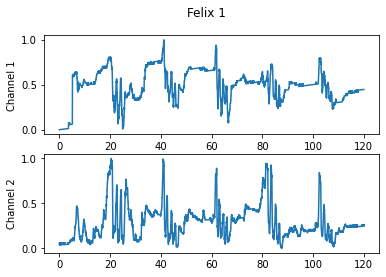

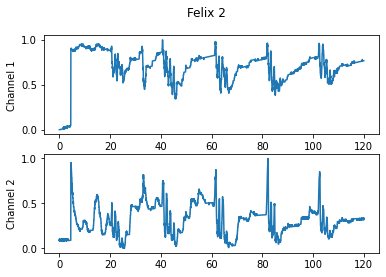

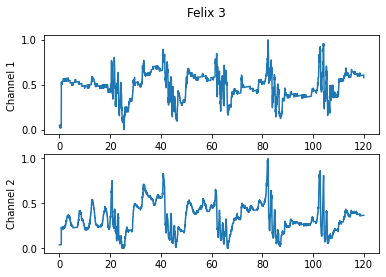

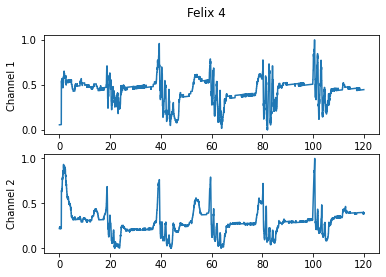

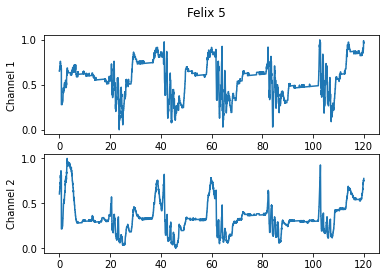

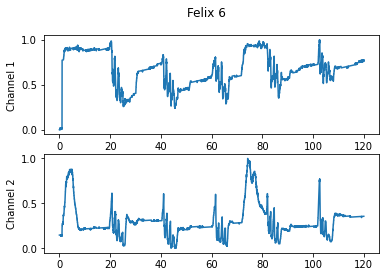

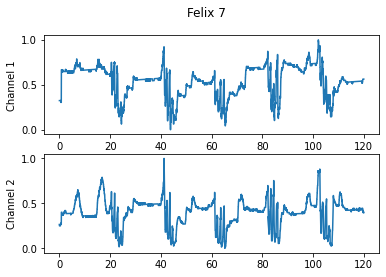

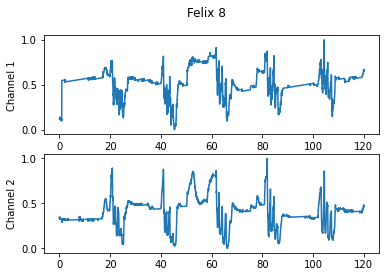

In [2]:
r1_ch1, r1_ch2 = read_data('data3/Felix_1.csv', normalize=True)
r2_ch1, r2_ch2 = read_data('data3/Felix_2.csv', normalize=True)
r3_ch1, r3_ch2 = read_data('data3/Felix_3.csv', normalize=True)
r4_ch1, r4_ch2 = read_data('data3/Felix_4.csv', normalize=True)
r5_ch1, r5_ch2 = read_data('data3/Felix_5.csv', normalize=True)
r6_ch1, r6_ch2 = read_data('data3/Felix_6.csv', normalize=True)
r7_ch1, r7_ch2 = read_data('data3/Felix_7.csv', normalize=True)
r8_ch1, r8_ch2 = read_data('data3/Felix_8.csv', normalize=True)
# Plot:
plot_data(r1_ch1, r1_ch2, 'Felix 1')
plot_data(r2_ch1, r2_ch2, 'Felix 2')
plot_data(r3_ch1, r3_ch2, 'Felix 3')
plot_data(r4_ch1, r4_ch2, 'Felix 4')
plot_data(r5_ch1, r5_ch2, 'Felix 5')
plot_data(r6_ch1, r6_ch2, 'Felix 6')
plot_data(r7_ch1, r7_ch2, 'Felix 7')
plot_data(r8_ch1, r8_ch2, 'Felix 8')


### Read and display the data for the second subject. There are 8 acquisitions.

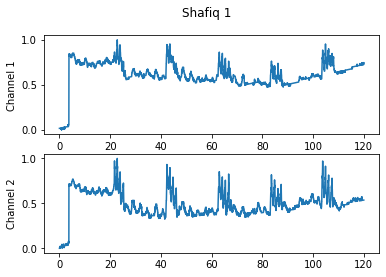

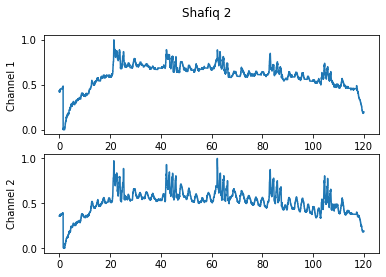

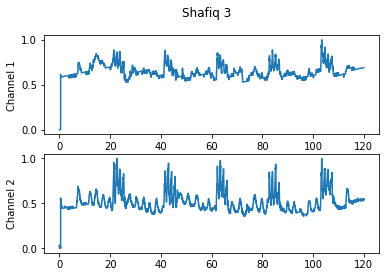

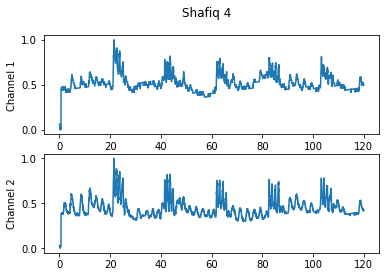

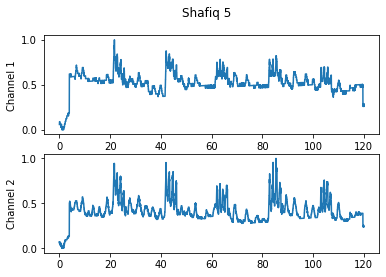

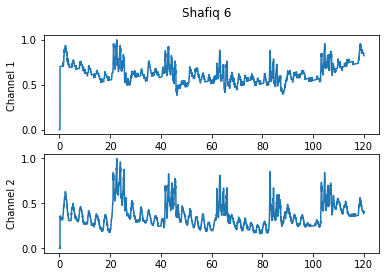

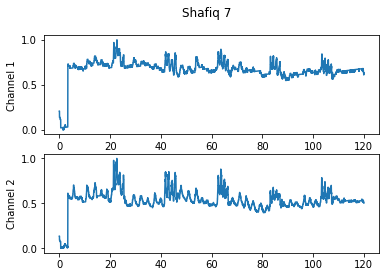

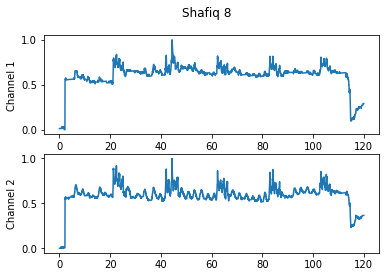

In [3]:

r9_ch1, r9_ch2 = read_data('data3/Shafiq_1.csv', normalize=True)
r10_ch1, r10_ch2 = read_data('data3/Shafiq_2.csv', normalize=True)
r11_ch1, r11_ch2 = read_data('data3/Shafiq_3.csv', normalize=True)
r12_ch1, r12_ch2 = read_data('data3/Shafiq_4.csv', normalize=True)
r13_ch1, r13_ch2 = read_data('data3/Shafiq_5.csv', normalize=True)
r14_ch1, r14_ch2 = read_data('data3/Shafiq_6.csv', normalize=True)
r15_ch1, r15_ch2 = read_data('data3/Shafiq_7.csv', normalize=True)
r16_ch1, r16_ch2 = read_data('data3/Shafiq_8.csv', normalize=True)
# plot
plot_data(r9_ch1, r9_ch2, 'Shafiq 1')
plot_data(r10_ch1, r10_ch2, 'Shafiq 2')
plot_data(r11_ch1, r11_ch2, 'Shafiq 3')
plot_data(r12_ch1, r12_ch2, 'Shafiq 4')
plot_data(r13_ch1, r13_ch2, 'Shafiq 5')
plot_data(r14_ch1, r14_ch2, 'Shafiq 6')
plot_data(r15_ch1, r15_ch2, 'Shafiq 7')
plot_data(r16_ch1, r16_ch2, 'Shafiq 8')

### Creating labels for coughing events:

##### Each dataset is acquired over 120 seconds. The first coughing event starts at 20 seconds, and has a duration of 5 seconds. We acquire coughing events every 20 seconds.

In [4]:
# cough_list = [ [cough 1 start, cough 1 stop], [cough 2 start, cough 2 stop],...]
cough_list = [[20, 25], [40, 45], [60, 65], [80, 85], [100, 105]]

# create labels:
label_c, label_nc = create_labels(len(r1_ch1), cough_list)

### Plot labeled datasets:

##### First subject:

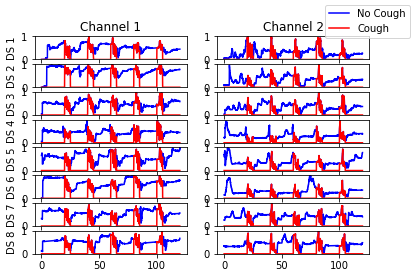

In [5]:
# list format: [ [dataset 1: ch1, ch2, labels], [dataset 2: ch1, ch2, labels], ... ]

subject_1 = [[r1_ch1, r1_ch2, label_c], [r2_ch1, r2_ch2, label_c], [r3_ch1, r3_ch2, label_c],
             [r4_ch1, r4_ch2, label_c], [r5_ch1, r5_ch2, label_c], [r6_ch1, r6_ch2, label_c],
             [r7_ch1, r7_ch2, label_c], [r8_ch1, r8_ch2, label_c]]

plot_labels(subject_1)

##### Second subject:

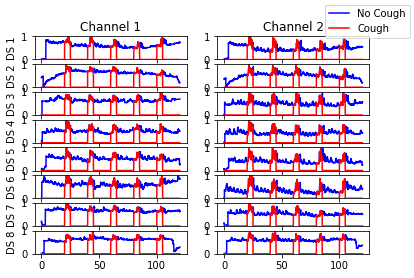

In [6]:
subject_2 = [[r9_ch1, r9_ch2, label_c], [r10_ch1, r10_ch2, label_c], [r11_ch1, r11_ch2, label_c],
             [r12_ch1, r12_ch2, label_c],
             [r13_ch1, r13_ch2, label_c], [r14_ch1, r14_ch2, label_c], [r15_ch1, r15_ch2, label_c],
             [r16_ch1, r16_ch2, label_c]]

plot_labels(subject_2)

### Concatenating all datasets into a single Pandas dataframe.

In [7]:
# Collect all data into a single list:
list_of_data = [[r1_ch1, r1_ch2, label_c], [r2_ch1, r2_ch2, label_c], [r3_ch1, r3_ch2, label_c],
                [r4_ch1, r4_ch2, label_c], [r5_ch1, r5_ch2, label_c], [r6_ch1, r6_ch2, label_c],
                [r7_ch1, r7_ch2, label_c], [r8_ch1, r8_ch2, label_c], [r9_ch1, r9_ch2, label_c],
                [r10_ch1, r10_ch2, label_c], [r11_ch1, r11_ch2, label_c], [r12_ch1, r12_ch2, label_c],
                [r13_ch1, r13_ch2, label_c], [r14_ch1, r14_ch2, label_c], [r15_ch1, r15_ch2, label_c],
                [r16_ch1, r16_ch2, label_c]]

index = np.int(np.floor(20 / .015))

for i in range(len(list_of_data)):
    for j in range(3):
        list_of_data[i][j] = list_of_data[i][j][index:]

# Convert list into Pandas dataframe:
data = concatenate_data(list_of_data)

##### All data is now organized into a single dataframe. The dataframe has 3 colums: Channel 1, Channel 2, and the corresponding label. If the label is "1", that timepoint is part of a coughing event. Here is how the first few rows of the dataframe look like:

In [8]:
data.head(10)

,Data ch1,Data ch2,Labels
0,0.782720,0.918216,0.0
1,0.782776,0.918241,1.0
2,0.805734,0.898191,1.0
3,0.805790,0.898217,1.0
4,0.805846,0.898243,1.0
5,0.783000,0.898269,1.0
6,0.805958,0.898295,1.0
7,0.806014,0.898320,1.0
8,0.783168,0.898346,1.0
9,0.783224,0.898372,1.0


### Partition dataframe into windows:

##### We can now partition the dataframe into windows. In this case, each window has a length of 250 datapoints (~ 3 seconds)

In [11]:
X, label_list = window_partition(data, 3, 250, 0)

### Implementing ML algorithms:

##### Here, we implement 4 classifiers: Support Vector Classifier, K-nearest means, Random Forest, and Logistic regression. The data is very imbalanced, so prior to training, the data is over-sampled with various techniques. For more info refer to: https://github.com/scikit-learn-contrib/imbalanced-learn. Also, some classifiers perform better when the data is normalized, so various scalers are also integrated in the grid search.

Implementing ML algorithms... Train/Test split used is 75/25.
Performing fit for the SVC classifier...
The best parameters for the SVC classifier are: 
smote  :  ADASYN(random_state=42)
standardscaler  :  StandardScaler()
svc__C  :  100
svc__class_weight  :  balanced
svc__gamma  :  0.0001
svc__kernel  :  rbf
The F1 score with the best parameter combination is 0.77 
The cross-validation scores for the best parameter combination are: 
split0_test_score        0.75
split1_test_score         0.8
split2_test_score    0.702703
split3_test_score    0.769231
split4_test_score    0.820513
Name: 0, dtype: object
The F1 score on the test set with the SVC classifier is 0.79 and the accuracy is 0.88



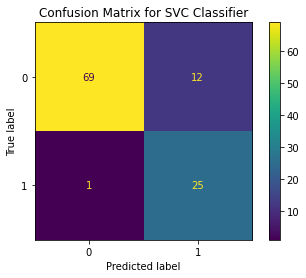

Performing fit for the KNN classifier...
The best parameters for the KNN classifier are: 
kneighborsclassifier__metric  :  minkowski
kneighborsclassifier__n_neighbors  :  8
smote  :  ADASYN(random_state=42)
standardscaler  :  StandardScaler()
The F1 score with the best parameter combination is 0.79 
The cross-validation scores for the best parameter combination are: 
split0_test_score    0.731707
split1_test_score    0.833333
split2_test_score    0.682927
split3_test_score    0.857143
split4_test_score    0.820513
Name: 0, dtype: object
The F1 score on the test set with the KNN classifier is 0.7 and the accuracy is 0.82



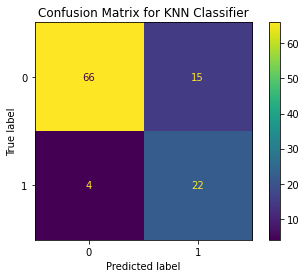

Performing fit for the Randon Forest classifier...
The best parameters for the RFC classifier are: 
randomforestclassifier__max_depth  :  12
randomforestclassifier__n_estimators  :  100
smote  :  SMOTE(random_state=42)
standardscaler  :  passthrough
The F1 score with the best parameter combination is 0.77 
The cross-validation scores for the best parameter combination are: 
split0_test_score    0.777778
split1_test_score    0.785714
split2_test_score    0.722222
split3_test_score    0.823529
split4_test_score    0.722222
Name: 0, dtype: object
The F1 score on the test set with the RFC classifier is 0.75 and the accuracy is 0.86



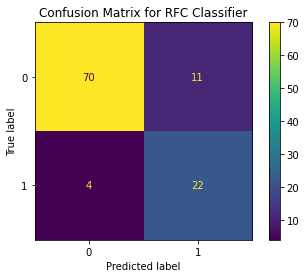

Performing fit for the Logistic Regression classifier...
The best parameters for the Log Reg classifier are: 
logisticregression__C  :  0.1
logisticregression__class_weight  :  None
smote  :  ADASYN(random_state=42)
standardscaler  :  StandardScaler()
The F1 score with the best parameter combination is 0.76 
The cross-validation scores for the best parameter combination are: 
split0_test_score    0.810811
split1_test_score    0.756757
split2_test_score    0.666667
split3_test_score    0.769231
split4_test_score    0.820513
Name: 0, dtype: object
The F1 score on the test set with the Log Reg classifier is 0.75 and the accuracy is 0.86



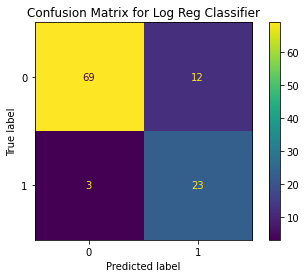

In [12]:
implement_ml(X, label_list)